### MAC5832 Aprendizado de Máquina - 2019/01
#### Projeto: análise de sentimento

##### Membros:
Nury - NUSP 9871836<br>
Patrícia - NUSP 6836726<br>
Rodrigo - NUSP 11361219

In [76]:
import os
import re
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from fastai.text import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
path = os.getcwd()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rodrigo.ney/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rodrigo.ney/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Explorando os dados

Primeiramente, vamos carregar o dataset na memória e entender suas especifícações. Faremos o minímo possível para evitar data snooping. Precisamos entender que colunas estão contidas no dataset e seu tamanho real, assim podemos pensar em técnicas mas adequadas para melhor performance com os dados que temos.

In [50]:
df_train_val = pd.read_csv('train_val_set.csv',sep=',', header = 0)
df_test = pd.read_csv('test_set.csv',sep=',', header = 0)

In [51]:
df_train_val.head(10)

,label,title_id,review
0,0,tt0406816,I went to the movie as a Sneak Preview in Aust...
1,0,tt0064354,Story of a man who has unnatural feelings for ...
2,1,tt0064354,"""All the world's a stage and its people actors..."
3,0,tt0077742,"""It appears that many critics find the idea of..."
4,0,tt0243931,This film is mediocre at best. Angie Harmon is...
5,0,tt0783608,Plot is not worth discussion even if it hints ...
6,0,tt0783608,This film is about a male escort getting invol...
7,0,tt0052844,I saw this movie at a drive-in in 1959. Until ...
8,0,tt0052844,Ghost of Dragstrip Hollow is a typical 1950's ...
9,0,tt0052844,"""Ghost of Dragstrip Hollow"" was one of the man..."


In [52]:
df_train_val.head(10)

,label,title_id,review
0,0,tt0406816,I went to the movie as a Sneak Preview in Aust...
1,0,tt0064354,Story of a man who has unnatural feelings for ...
2,1,tt0064354,"""All the world's a stage and its people actors..."
3,0,tt0077742,"""It appears that many critics find the idea of..."
4,0,tt0243931,This film is mediocre at best. Angie Harmon is...
5,0,tt0783608,Plot is not worth discussion even if it hints ...
6,0,tt0783608,This film is about a male escort getting invol...
7,0,tt0052844,I saw this movie at a drive-in in 1959. Until ...
8,0,tt0052844,Ghost of Dragstrip Hollow is a typical 1950's ...
9,0,tt0052844,"""Ghost of Dragstrip Hollow"" was one of the man..."


In [53]:
df_train_val['review'][0]

"I went to the movie as a Sneak Preview in Austria. So didn't have an idea what I am going to see. The story is very normal. The movie is very long , I believe it could have cut to 1/2 without causing any problems to the story. Its the type of movie you can see in a boring night which you want to get bored more ! Ashton Kutcher was very good . Kevin Costner is OK. The movie is speaking about the US Coast Guards, how they are trained , their life style and the problems they face. As there aren't much effects in the movie. So if you want to watch it , then no need to waste your money and time going to the Cinema. Would be more effective to watch it at home when it gets on DVDs."

In [54]:
df_train_val['label'][0]

0

A label "0" indica um review negativo, já a label "1" indica um review positivo.

In [55]:
df_train_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8525 entries, 0 to 8524
Data columns (total 3 columns):
label       8525 non-null int64
title_id    8525 non-null object
review      8525 non-null object
dtypes: int64(1), object(2)
memory usage: 199.9+ KB


8525 reviews dentro do dataset de treino e validação.

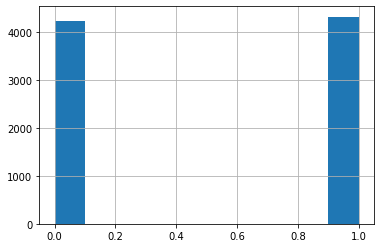

In [56]:
df_train_val['label'].hist()

*   0 (negativo), 1 (positivo)
*   Dataset balanceado

In [57]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Data columns (total 3 columns):
submission_id    8708 non-null int64
title_id         8708 non-null object
review           8708 non-null object
dtypes: int64(1), object(2)
memory usage: 204.2+ KB


8708 reviews para serem classificados e submetidos para o kaggle

### Explorando os reviews

In [58]:
train_review = df_train_val['review']
train_review[:10]

0    I went to the movie as a Sneak Preview in Aust...
1    Story of a man who has unnatural feelings for ...
2    "All the world's a stage and its people actors...
3    "It appears that many critics find the idea of...
4    This film is mediocre at best. Angie Harmon is...
5    Plot is not worth discussion even if it hints ...
6    This film is about a male escort getting invol...
7    I saw this movie at a drive-in in 1959. Until ...
8    Ghost of Dragstrip Hollow is a typical 1950's ...
9    "Ghost of Dragstrip Hollow" was one of the man...
Name: review, dtype: object

# Primeira abordagem - Classificador Linear

*Para* melhor processar o dataset **train_review**, nós decidimos trabalhar com *stopwords* e *punctuations*, eliminando as mesmas do dataset.

In [59]:
# Stop words in english vocabulary
en_stopwords = list(set(stopwords.words('english')))
print('Numero de stopwords: ' + str(len(en_stopwords)))
print('Exemplos: ' + str(en_stopwords[:10]))

Numero de stopwords: 179
Exemplos: ['a', 'under', 'very', 'against', 'once', "mustn't", 'don', 'had', 's', "it's"]


In [60]:
# remove punctuation from data
def remove_punctuation(text):
  return [re.sub(r'[^\w\s]','',i).lower() for i in text]

Removendo as *punctiation* do dataset

In [61]:
train_review = remove_punctuation(train_review)
train_review[:5]

['i went to the movie as a sneak preview in austria so didnt have an idea what i am going to see the story is very normal the movie is very long  i believe it could have cut to 12 without causing any problems to the story its the type of movie you can see in a boring night which you want to get bored more  ashton kutcher was very good  kevin costner is ok the movie is speaking about the us coast guards how they are trained  their life style and the problems they face as there arent much effects in the movie so if you want to watch it  then no need to waste your money and time going to the cinema would be more effective to watch it at home when it gets on dvds',
 'story of a man who has unnatural feelings for a pig starts out with a opening scene that is a terrific example of absurd comedy a formal orchestra audience is turned into an insane violent mob by the crazy chantings of its singers unfortunately it stays absurd the whole time with no general narrative eventually making it just 

In [62]:
# Remove stop words
def remove_stopwords(text):
  tokens = [word_tokenize(x) for x in text]
  filtered_tokens = []
  # Tokens that are not stopwords collected here
  for i in tokens:
    document_tockens = []
    for j in i:
      if j not in en_stopwords:
        document_tockens.append(j)
    filtered_tokens.append(document_tockens)
  return filtered_tokens

Removendo as *stopwords* do dataset. Depois de remover, as sentenças são representadas como uma coleção de palavras.

In [63]:
train_review = remove_stopwords(train_review)
train_review[0]

['went',
 'movie',
 'sneak',
 'preview',
 'austria',
 'didnt',
 'idea',
 'going',
 'see',
 'story',
 'normal',
 'movie',
 'long',
 'believe',
 'could',
 'cut',
 '12',
 'without',
 'causing',
 'problems',
 'story',
 'type',
 'movie',
 'see',
 'boring',
 'night',
 'want',
 'get',
 'bored',
 'ashton',
 'kutcher',
 'good',
 'kevin',
 'costner',
 'ok',
 'movie',
 'speaking',
 'us',
 'coast',
 'guards',
 'trained',
 'life',
 'style',
 'problems',
 'face',
 'arent',
 'much',
 'effects',
 'movie',
 'want',
 'watch',
 'need',
 'waste',
 'money',
 'time',
 'going',
 'cinema',
 'would',
 'effective',
 'watch',
 'home',
 'gets',
 'dvds']

In [64]:
corpus_clean = []
for tokens in train_review:
  corpus_clean.append(' '.join(tokens))
corpus_clean[:3]

['went movie sneak preview austria didnt idea going see story normal movie long believe could cut 12 without causing problems story type movie see boring night want get bored ashton kutcher good kevin costner ok movie speaking us coast guards trained life style problems face arent much effects movie want watch need waste money time going cinema would effective watch home gets dvds',
 'story man unnatural feelings pig starts opening scene terrific example absurd comedy formal orchestra audience turned insane violent mob crazy chantings singers unfortunately stays absurd whole time general narrative eventually making putting even era turned cryptic dialogue would make shakespeare seem easy third grader technical level better might think good cinematography future great vilmos zsigmond future stars sally kirkland frederic forrest seen briefly',
 'worlds stage people actors itor something like hell said theatre stopped orchestra pitor even theatre door audience participants theatrical expe

Vamos criar uma função para realizar o trabalho:

In [65]:
def text_processing(text):
  corpus_clean = []
  text_withoutpunctuation = remove_punctuation(text)
  text_withoutstopwords = remove_stopwords(text_withoutpunctuation)
  # join tokens  
  for tokens in text_withoutstopwords:
    corpus_clean.append(' '.join(tokens))
  return corpus_clean

## Extração das features

In [68]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(corpus_clean)

In [69]:
print(vectorizer.get_feature_names())

['0000000000001', '00000110', '001', '002', '007', '00s', '01', '010', '01000', '0110', '02', '029', '048', '05', '050', '0510', '06', '07', '08', '087', '0f', '0r', '0stars', '10', '100', '1000', '10000', '1000000', '1000s', '100min', '100minute', '100th', '100x', '101', '1010', '1011', '1015', '102', '1025', '103', '1030pm', '104', '105', '107', '109', '10dirjim', '10highly', '10i', '10its', '10just', '10line', '10pm', '10s', '10star', '10th', '10times', '10year', '10yearold', '10yr', '11', '110', '1100', '110jd', '1110', '112', '112443', '114', '116', '117', '119', '11th', '11year', '11yearold', '12', '120', '1200f', '1201', '1201pm', '121031', '1214', '123', '125', '125m', '128', '12a', '12episode', '12s', '12th', '12yearold', '12years', '13', '130', '1300', '1314', '133', '1331', '134', '13th', '13thclone', '14', '140', '1400', '1410', '149', '1498', '14th', '15', '150', '1500', '15000', '150k', '150m', '1510', '157', '15hrs', '15mins', '15minute', '15th', '15year', '16', '160', '

In [70]:
print(X_train.shape)

(8525, 37795)


Temos 8525 exemplos e um vetor de features de tamanho 37795.

In [72]:
y_train = df_train_val['label']
y_train[:10]

0    0
1    0
2    1
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: label, dtype: int64

Separamos então em treino e validação

In [74]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.33, random_state=42)

## Linear classifier

In [77]:
classifiers = [LinearSVC()]
candidate_classifier = LinearSVC()

In [78]:
candidate_classifier.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

## Testando a acurácia

In [82]:
def accuracy(clf,X,y):
    scores = cross_val_score(clf, X, y, cv=5)
    results = cross_val_predict(clf, X, y, cv=5)
    print("Cross-validated Scores: ", scores)
    avg_accuracy = metrics.accuracy_score(y, results)
    print("Acurácia média: ", avg_accuracy)

In [83]:
accuracy(candidate_classifier,X_train,y_train)

Cross-validated Scores:  [0.88014  0.872266 0.858144 0.863398 0.86766 ]
Acurácia média:  0.8683242864647173


Temos uma acurácia de **86%**-**87%** com o classificador linear, *in sample*.

## Prevendo com o classificador linear

In [86]:
# text processing
test_data_processed = text_processing(df_test['review'])
test_data_processed[:3]

['funny thing happened watching mosquito one hand hero deafmute director totally unable make us understand mutilating mannequinser excuse corpses images hand english version least badly dubbed found wishing less dialogue time film stupid funny guy access every graveyard mortuary town lurid would 70s exploitationer without gratuitous lesbian scene mention romantic aspect oh sweetmiss',
 'longtime fan japanese film expected cant really bothered write much movie poor story might cutest romantic little something ever pity couldnt stand awful acting mess called pacing standard quirky japanese story youve noticed many japanese movies use characters plots twists seem different forcedly steer clear movie seriously 12year old could told movie going move along thats good thing book fans beat takeshi part movie really cameo unless youre rabid fan dont need suffer waste film 210',
 'tokyo eyes tells 17 year old japanese girl falls like man hunted big bro cop lame flick 50 filler 50 talk talk talk 

In [87]:
# feature extrating
X_test = vectorizer.transform(test_data_processed)
print(vectorizer.get_feature_names())

['0000000000001', '00000110', '001', '002', '007', '00s', '01', '010', '01000', '0110', '02', '029', '048', '05', '050', '0510', '06', '07', '08', '087', '0f', '0r', '0stars', '10', '100', '1000', '10000', '1000000', '1000s', '100min', '100minute', '100th', '100x', '101', '1010', '1011', '1015', '102', '1025', '103', '1030pm', '104', '105', '107', '109', '10dirjim', '10highly', '10i', '10its', '10just', '10line', '10pm', '10s', '10star', '10th', '10times', '10year', '10yearold', '10yr', '11', '110', '1100', '110jd', '1110', '112', '112443', '114', '116', '117', '119', '11th', '11year', '11yearold', '12', '120', '1200f', '1201', '1201pm', '121031', '1214', '123', '125', '125m', '128', '12a', '12episode', '12s', '12th', '12yearold', '12years', '13', '130', '1300', '1314', '133', '1331', '134', '13th', '13thclone', '14', '140', '1400', '1410', '149', '1498', '14th', '15', '150', '1500', '15000', '150k', '150m', '1510', '157', '15hrs', '15mins', '15minute', '15th', '15year', '16', '160', '

In [88]:
# predict
predict = candidate_classifier.predict(X_test)

In [90]:
print('Array de previsões: ' + str(predict))

Array de previsões: [0 0 0 0 ... 0 1 0 1]


Montando o arquivo de submissão:

In [91]:
final = pd.DataFrame({
    "submission_id": df_test['submission_id'],
    "label": predict
})

In [92]:
final.to_csv("sentiment_analysis.csv", index=False)
print(final.shape)

(8708, 2)


In [93]:
final.head(10)

,submission_id,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,1
6,6,1
7,7,0
8,8,0
9,9,0


# Segunda abordagem - Deep Learning com fast.ai

Por muito tempo as pessoas tem usado classificadores de texto usando apenas **labels** para treinar o modelo. Com novos estudos, muitos bons resultados estão sendo produzidos usando modelos pré treinados ao invés de pesos randomicos. Transferência de aprendizagem está novamente fazendo uma enorme diferença.

Aqui criaremos um *language model* com os dados do **IMBD** e usaremos o mesmo para treinar o classificador. 

## Tokenização e numerização

In [6]:
data_lm = TextLMDataBunch.from_csv(path, 'train_val_set.csv', text_cols='review', label_cols='label')

In [7]:
data_lm.show_batch()

idx,text
0,"nothing without husbands and children . i can hardly believe how regressive it is in it 's view of women . xxmaj has the writer been living under a rock ? xxmaj although i enjoyed seeing my beloved city on the big screen , i would n't suggest this movie to anyone . xxmaj it 's terrible . xxmaj it 's an embarrassment to the city it 's named after"
1,"two . xxmaj this is the first movie i have ever seen where it was implied that it was your religious duty to go to it and buy as many tickets as possible to save souls ... very shameful ... this just goes to show that if you are a televangelist 's son , you too can play high - roller xxmaj hollywood producer with lil ole ladies tithe money"
2,", and really let 's face it xxup that film was n't exactly comedy gold either , so you get a ' movie ' worse than one that was moderately funny . xxmaj in my eyes that xxup still puts it one or two xxunk above "" xxmaj kicking and xxmaj screaming "" , or "" xxmaj bewitched "" . xxmaj xxunk your fingers that "" xxmaj the xxmaj wedding"
3,"xxmaj meryl xxmaj streep was incredible in this film . xxmaj she has an amazing knack for accents , and she shows incredible skill in this film overall . i really felt for her when xxmaj lindy was being persecuted . xxmaj she was played realistically , too . xxmaj she got cranky , upset , and unpleasant as the media and the government continued their xxunk xxunk . i"
4,xxmaj richard gets a 5 . xxbos xxmaj the xxup tv guide calls this movie a mystery . xxmaj what is a mystery to me is how is it possible that a culture that can produce such intricate and complex classical music and brilliant xxunk can not produce a single film that would rise above the despicable trash level this film so perfectly represents . xxmaj this is xxmaj bollywood


A classe *TextLMDataBunch* já cria um *TextDataBunch* pronto para ser submetido para um treinamento de *language model*. Um *TextDataBunch* é a estrutura de dados usada pela **fast.ai** para NLP.

O que aconteceu debaixo dos panos? Basicamente foram criadas unidades separadas, os *"tokens"*, para partes de palavras. A maioria dos tokens são para palavras, mas também podem aparacer em contrações como *it's*. Pontuações tambem podem ganhar seu próprio token (geralmente o próprio símbolo, como *"."*).

In [8]:
data_lm.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.']

Também foi executada a numerização. É uma lista de todos os tokens criados e ordenado por frequência.
A lista de *tokens* únicos é chamada de vocabulário. 

In [9]:
data_lm.train_ds[0][0]

Text xxbos xxmaj as a former xxmaj xxunk resident with a fondness for the town i was looking forward to seeing this movie . xxmaj but , what a disappointment ! xxmaj although the acting and the production values are n't bad , the script is awful , the plot is unrealistic , and the theme is disturbing . xxmaj the main message of this film is that xxmaj women are nothing without husbands and children . i can hardly believe how regressive it is in it 's view of women . xxmaj has the writer been living under a rock ? xxmaj although i enjoyed seeing my beloved city on the big screen , i would n't suggest this movie to anyone . xxmaj it 's terrible . xxmaj it 's an embarrassment to the city it 's named after .

In [10]:
data_lm.train_ds[0][0].data[:10]

array([   2,    5,   32,   12, 1634,    5,    0, 4098,   33,   12])

Esses tokens são então *"trocados"* por ID's da posição deles no vocabulário, em ordem de numeração. No fim tudo se torna números.

In [11]:
data_clas = TextClasDataBunch.from_csv(path, 'train_val_set.csv', test='test_set.csv', text_cols='review', label_cols='label', vocab=data_lm.train_ds.vocab)

Para fazer o carregamento dos dados para a classificação, queremos ter certeza que usamos o mesmo vocabulário. Por isso passamos essa informação como parametro.

In [12]:
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

In [13]:
data_lm = load_data(path, 'data_lm_export.pkl')
data_clas = load_data(path, 'data_clas_export.pkl', bs=16)

Depois de criar as estruturas de dados, salvamos elas em disco para evitar a necessidade de re-execução.

# Treinamento do Modelo de Linguagem

Não estamos ainda treinando o classificador. Aqui treinaremos o modelo que interpreta a linguagem e salvaremos ele como o nosso encoder para o classificador.

In [14]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.146551,3.880380,0.293565,21:55


In [15]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.796523,3.764375,0.308314,47:26


Basicamente o que aconteceu é que não criamos uma CNN (Convolutional Neural Network), mas sim uma RNN (Recurrent Neural Network). A entrada passa por um vetor de pesos, para substituir os negativos por zeros, e então passa por outra multiplicação de matrizes e o ciclo se repete por várias vezes. 

[AWD_LSTM](https://docs.fast.ai/text.models.html#AWD_LSTM) é a *arch* inspirada em: https://arxiv.org/abs/1708.02182


Na primeira interação fizemos o fine tunning das últimas camadas. Geralmente depois disso damos um *unfreeze* e treinamos o resto.

Com o modelo pronto, podemos prever o que seriam as próximas palavras de uma frase, por exemplo, de 10 palavras: 

In [16]:
learn.predict("This is a review about", n_words=10)

'This is a review about operas ( mostly as used ( beyond the word )'

Salvamos o modelo pré treinado como nosso encoder e carregamos ele para ser usado pelo nosso classificador. O encoder é a parte que entende a frase que esta escrita, não precisamos mais do que isso para o classificador. Mantemos a *arch* [AWD_LSTM](https://docs.fast.ai/text.models.html#AWD_LSTM) para o classificador.

In [17]:
learn.save_encoder('ft_enc')

In [18]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')

In [19]:
data_clas.show_batch()

text,target
xxbos xxmaj smallville episode xxmaj justice is the best episode of xxmaj smallville ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !,1
"xxbos xxmaj this is one of the greatest 80s movies ! ! ! xxmaj it sticks out like a "" turd in a xxunk "" ! ! i ca n't believe xxmaj mad xxmaj magazine xxunk it or whatever . xxmaj and yet , they proudly put their name on a show with "" xxmaj stuart "" , "" i - speak - a - no - xxunk xxmaj chinese",1
"xxbos "" xxmaj someones at the xxmaj door "" . xxup xxunk , xxmaj how i miss this show so bad .. but we are lucky to now have "" xxmaj invasion "" . xxmaj thank xxmaj you , xxmaj shawn xxmaj cassidy . xxmaj american xxmaj gothic , had it all . xxmaj if i had to pick one thing that i liked best about the show , it",1
"xxbos xxmaj what can i say ? ? ? xxmaj this movie was so xxmaj dumb & xxmaj stupid i thought it was a xxmaj psychotic xxup drag xxmaj comedy - xxmaj they should rename it "" xxmaj bitching xxmaj pregnant xxmaj cat xxmaj fight ! "" xxmaj what a stupid waste of time , if you want to xxunk xxup die ! ! ! "" i xxup want xxup",0
"xxbos xxmaj this is one of the worst movies i have seen to date , the best part was xxmaj christian xxup j. xxmaj xxunk "" xxmaj leonard "" attempting to act jumping up and down outside the bar , kind - of like i wanted to do on the xxup dvd , to spare the rest of humanity the agony of watching this shitty film . xxmaj it has",0


In [20]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.382628,0.326037,0.862837,16:02


In [21]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.306864,0.283251,0.889801,22:50


In [22]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.340799,0.259067,0.907386,1:31:08


In [23]:
learn.predict("This was a great movie!")

(Category 1, tensor(1), tensor([0.0083, 0.9917]))

Os passos para o treinamento são bem parecidos com os anteriores, a maior diferença é que para o classificador nos provemos o modelo pré treinado (enconder). A função nova *freeze_to(-2)* esta basicamente dando um *unfreeze* apenas nas duas ultimas camadas. A acurácia aqui foi maior que a do modelo linear - 90%!

In [24]:
learn.save('imdb_classifier')

In [25]:
learn.show_results()

text,target,prediction
"xxbos xxup the xxup invaders xxup is a xxup fast xxup moving xxup sci - xxup fi xxup thriller xxup starring xxup ben xxup cross xxup and xxup sean xxup young . xxup ben xxup plays xxup xxunk , a xxup xxunk xxup from xxup another xxup galaxy xxup trying xxup to xxup find xxup annie ( xxup played xxup by xxup sean ) xxup who xxup is xxup physically",1,1
"xxbos xxmaj the xxmaj three xxmaj stooges in a feature length western comedy - musical ? xxmaj perhaps "" xxmaj rockin ' in the xxmaj rockies "" was meant to combine the xxmaj stooges comedy short with the western musical , in a matinã © e ; if so , this was a pleasant way to break up a xxmaj saturday afternoon . xxmaj jay xxmaj xxunk ( as xxmaj",0,0
"xxbos xxmaj it is one of the worst movies i 've ever seen , but xxmaj hostel is definitely much more worse . xxmaj this movie is more funny and ridiculous , than scary . i laughed most of the time when watched it . xxmaj low quality effects ( when you gon na watch it , you 'll understand what i 'm talking about and xxup how xxup low",0,0
"xxbos xxmaj yeah , it 's low budget . xxmaj yeah , it 's one of xxmaj candy 's earliest films , but it is maybe his funniest ! xxmaj john xxmaj candy was not so far removed from his xxup sctv days in "" xxmaj going xxmaj berserk "" and it shows . xxmaj if you do n't crack up when xxmaj candy tries to help a guy with",1,1
"xxbos i am a xxup very big xxmaj jim xxmaj carrey fan . i laughed my xxup ass off during xxmaj liar xxmaj liar and xxmaj ace xxmaj xxunk . i also like him in his serious movies , especially xxmaj truman xxmaj show . xxmaj this one is a cross between his xxup very funny side , and his serious side . xxmaj he is of course xxup very",1,1


## Prevendo com fast.ai

In [26]:
learn.data.train_ds

LabelList (6819 items)
x: TextList
xxbos xxmaj this movie was disaster at xxmaj box xxmaj office , and the reason behind that is innocence of the movie , sweetness of the story . xxmaj music was good , story is very simple and old , but presentation of such story is very good , xxmaj director tried his best . xxmaj abhay is excellent and impressive and he shines once again in his role , he did his best in comedy or in emotional scene . xxmaj xxunk looks so sweet in the movie . xxmaj rest star cast was simply okay . xxmaj music and all songs are good , xxmaj xxunk is impressive as an xxmaj singer here . xxmaj do n't miss this movie , its a wonderful movie and a feel good one for us . xxmaj abhay best work till date . i will give 9 / 10 to xxmaj ahista xxmaj ahista .,xxbos i wanted to like xxmaj magnolia . xxmaj the plot reminded me of xxmaj grand xxmaj canyon ( which i liked ) . 4 different lives / stories that come together at the end but xxmaj magnolia took a wrong turn halfway throug

In [27]:
learn.data.valid_ds

LabelList (1706 items)
x: TextList
xxbos xxmaj when his in - laws are viciously murdered by a gang of thugs , a young deputy is ordered to escort his mute friend , forced to take the rap by the gang , to xxmaj tucson for trial and ending up having to face the real killers along the way . xxmaj the xxmaj decoy is a real - life decoy sent to video stores to lure you away from better films ! xxmaj it 's talky , illogical , slow , and ultimately very boring . xxmaj there 's some good costumes , sets , and photography but nothing else is good about this vanity project from writer / director / producer / star xxmaj justin xxmaj xxunk , who apparently had too much money on his hands . xxmaj they used to make westerns like this , that were under an hour long . xxmaj xxunk this of about half it 's length and you might have something watchable .,xxbos a grade - z horror filmmaker xxmaj carl xxmaj monson was one of the most prolific directors operating within the field of the low - budget gory ma

In [28]:
learn.data.test_ds

LabelList (8708 items)
x: TextList
xxbos a funny thing happened to me while watching " xxmaj xxunk " : on the one hand , the hero is a deaf - mute and the director is totally unable to make us understand why he does what he does ( xxunk xxunk ... er , excuse me , corpses ) through his images . xxmaj on the other hand , the xxmaj english version at least is very badly dubbed . xxmaj so i found myself wishing there had been both more xxup and less dialogue at the same time ! xxmaj this film is stupid ( funny how this guy has access to every graveyard and xxunk in his town ) and lurid ( where would we be in a 70s xxunk without our gratuitous lesbian scene ? ) . xxmaj not to mention the " romantic " aspect ( oh , how xxunk ... xxmaj miss it . ( * ),xxbos xxmaj being a long - time fan of xxmaj japanese film , i expected more than this . i ca n't really be bothered to write to much , as this movie is just so poor . xxmaj the story might be the cutest romantic little something ever , pity i c

### Previsão em batch com getpreds

In [34]:
preds, y_test = learn.get_preds(DatasetType.Test)

In [35]:
labels = np.argmax(preds, 1)
labels

tensor([1, 0, 1,  ..., 0, 1, 0])

In [36]:
labels.shape

torch.Size([8708])

In [50]:
submission_df = learn.data.test_ds.inner_df
submission_df.head(10)

,submission_id,title_id,review,getpreds
0,0,tt0074920,"A funny thing happened to me while watching ""M...",1
1,1,tt0157117,"Being a long-time fan of Japanese film, I expe...",0
2,2,tt0157117,"""Tokyo Eyes"" tells of a 17 year old Japanese g...",1
3,3,tt0113627,Cage plays a drunk and gets high critically pr...,0
4,4,tt0113627,A big disappointment for what was touted as an...,1
5,5,tt0085540,At the bottom end of the apocalypse movie scal...,0
6,6,tt0052878,New York family is the last in their neighborh...,0
7,7,tt0086137,"The best thing about ""The Prey"" is the tag lin...",1
8,8,tt0086137,Even by the lowered standards of '80s slasher ...,1
9,9,tt0433341,Thank God I didn't buy this movie myself! I bo...,0


Usando o método *getpreds*, por algum motivo tivemos problemas com o batch size utilizado. As previsões não parecerem fazer sentido. Fomos forçados a utilizar a previsão linha por linha.

In [51]:
submission_df['getpreds'] = labels

In [59]:
submission_df.head(20)

,submission_id,title_id,review,getpreds
0,0,tt0074920,"A funny thing happened to me while watching ""M...",1
1,1,tt0157117,"Being a long-time fan of Japanese film, I expe...",0
2,2,tt0157117,"""Tokyo Eyes"" tells of a 17 year old Japanese g...",1
3,3,tt0113627,Cage plays a drunk and gets high critically pr...,0
4,4,tt0113627,A big disappointment for what was touted as an...,1
5,5,tt0085540,At the bottom end of the apocalypse movie scal...,0
6,6,tt0052878,New York family is the last in their neighborh...,0
7,7,tt0086137,"The best thing about ""The Prey"" is the tag lin...",1
8,8,tt0086137,Even by the lowered standards of '80s slasher ...,1
9,9,tt0433341,Thank God I didn't buy this movie myself! I bo...,0


### Previsão em loop com .predict()

In [62]:
single_predictions = []
for row in submission_df['review']:
    single_predictions.append(learn.predict(row)[0])

submission_df['label'] = single_predictions
submission_df.head(20)

,submission_id,title_id,review,getpreds,label
0,0,tt0074920,"A funny thing happened to me while watching ""M...",1,0
1,1,tt0157117,"Being a long-time fan of Japanese film, I expe...",0,0
2,2,tt0157117,"""Tokyo Eyes"" tells of a 17 year old Japanese g...",1,0
3,3,tt0113627,Cage plays a drunk and gets high critically pr...,0,0
4,4,tt0113627,A big disappointment for what was touted as an...,1,0
5,5,tt0085540,At the bottom end of the apocalypse movie scal...,0,0
6,6,tt0052878,New York family is the last in their neighborh...,0,0
7,7,tt0086137,"The best thing about ""The Prey"" is the tag lin...",1,0
8,8,tt0086137,Even by the lowered standards of '80s slasher ...,1,0
9,9,tt0433341,Thank God I didn't buy this movie myself! I bo...,0,0


# Criando o arquivo para a submissão

In [63]:
submission_df.to_csv('submision_all_columns.csv')

In [65]:
kaggle_submission_df = submission_df.copy()
del kaggle_submission_df['title_id']
del kaggle_submission_df['review']
del kaggle_submission_df['getpreds']
kaggle_submission_df.to_csv('kaggle_submission_chevere.csv', index=False)

# Textos/Tutoriais
Analyzing Text with the Natural Language Toolkit (NLTK 3) [http://www.nltk.org/book/]

Natural Language Processing Tutorial [http://www.vikparuchuri.com/blog/natural-language-processing-tutorial/]

My solution to achieve top 1% in a novel Data Science NLP Competition [https://becominghuman.ai/my-solution-to-achieve-top-1-in-a-novel-data-science-nlp-competition-db8db2ee356a]

Fast.ai-text: https://docs.fast.ai/text.html

Tutorial: https://www.freecodecamp.org/news/an-introduction-to-bag-of-words-and-how-to-code-it-in-python-for-nlp-282e87a9da04/